In [103]:
import gt_sampling
import sys
import torch
sys.path.append('../utils')

from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import utils
import numpy as np

In [76]:
f_number = 1
n_dim = 2

problem_1 = utils.create_problem(f_number, n_dim, seed=42)
problem_2 = utils.create_problem(f_number, n_dim, seed=187)

functions = [[problem_1, 'Problem_seed42'], [problem_2, 'Problem_seed187']]

In [43]:
def random_search_optimization(function, n_dim, num_iterations=100, search_range=(-5.0, 5.0)):
    best_inputs = []
    best_outputs = []

    best_input = None
    best_output = float('inf')

    for _ in range(num_iterations):
        # Generate a random tensor input within the search range
        random_input = torch.rand(n_dim) * (search_range[1] - search_range[0]) + search_range[0]

        # Compute the output of the function for the random input
        output = function(random_input)

        # Check if the current output is better than the best found so far
        if output < best_output:
            best_output = output
            best_input = random_input

        # Save the best input and output at this iteration
        best_inputs.append(best_input)
        best_outputs.append(best_output.item())

    return best_inputs, best_outputs

In [68]:
def gradient_descent_optimization(function, n_dim, num_iterations=100, learning_rate=0.01, search_range=(-5.0, 5.0)):
    best_inputs = []
    best_outputs = []

    # Initialize random input tensor within the search range
    best_input = torch.rand(n_dim) * (search_range[1] - search_range[0]) + search_range[0]
    best_input.requires_grad = True  # Set requires_grad to True for autograd

    best_output = function(best_input)

    for _ in range(num_iterations):
        # Perform a forward pass to compute the output
        output = function(best_input)

        # Clear gradients from the previous iteration
        best_input.grad = None

        # Compute gradients using automatic differentiation
        output.backward()

        # Update the parameters using the computed gradients with gradient descent
        with torch.no_grad():
            best_input -= learning_rate * best_input.grad

        # Update the best output and input if needed
        if output < best_output:
            best_output = output
            best_inputs.append(best_input.detach().clone().cpu().numpy())  # Store the best input (detach to avoid gradients)
            best_outputs.append(best_output.item())

    return best_inputs, best_outputs

In [108]:
def evolutionary_optimization(function, n_dim, num_iterations, search_range=(-5, 5)):
    def callback_fn(xk, convergence):
        intermediate_results.append((xk, function(xk)))

    # List to store intermediate results
    intermediate_results = []

    # Define the bounds for each dimension of the input tensor
    bounds = [search_range] * n_dim

    # Perform differential evolution optimization with callback function
    result = differential_evolution(function, bounds=bounds, callback=callback_fn)

    # Extract intermediate results
    best_inputs, best_outputs = zip(*intermediate_results)

    # Convert lists to numpy arrays
    best_inputs = np.array(best_inputs)
    best_outputs = np.array(best_outputs)

    return best_inputs, best_outputs

In [93]:
def get_optimum(function):
    return function(function.x_opt).item()

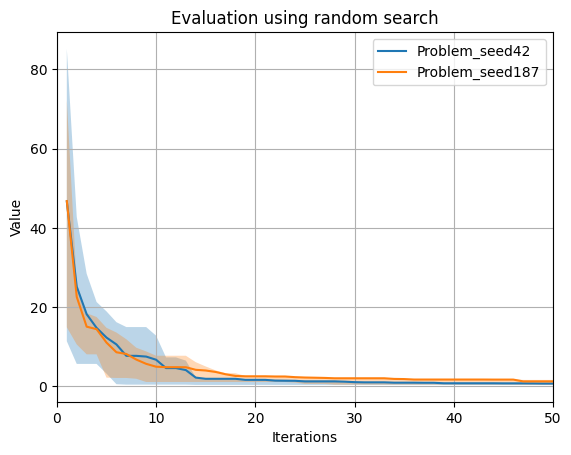

In [110]:
n_times = 20  # Number of times to repeat the random search
i_evaluations = 50  # Number of evaluations in each random search

for elem in functions:

    results = []
    optimum = get_optimum(elem[0])

    # Perform random search 'n_times' times and store the results
    for _ in range(n_times):
        best_inputs, best_outputs = random_search_optimization(elem[0], n_dim, num_iterations=i_evaluations)
        results.append(np.array(best_outputs)-optimum)

    # Calculate the mean and interquartile range (IQR) for each evaluation
    mean_values = np.mean(results, axis=0)
    q1 = np.percentile(results, 75, axis=0) 
    q3 = np.percentile(results, 25, axis=0)

    x = [i for i in range(1, len(mean_values)+1)]

    plt.plot(x, mean_values, label=f'{elem[1]}')
    plt.fill_between(x, q1, q3,  alpha=0.3)


plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.xlim(0, len(mean_values))
plt.title('Evaluation using random search')
plt.grid(True)
plt.show()

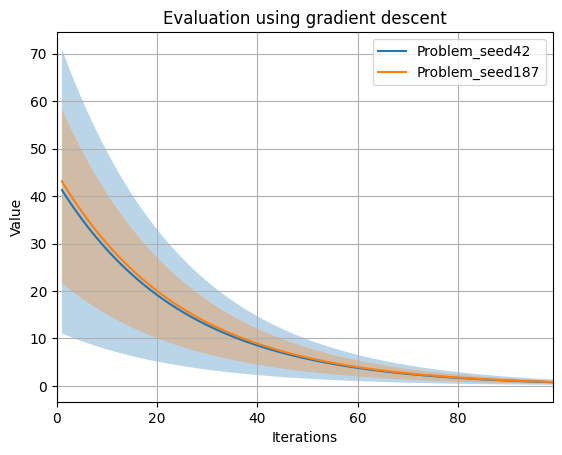

In [115]:
n_times = 20  # Number of times to repeat the random search
i_evaluations = 100  # Number of evaluations in each random search

for elem in functions:

    results = []    
    optimum = get_optimum(elem[0])

    # Perform random search 'n_times' times and store the results
    for _ in range(n_times):
        best_inputs, best_outputs = gradient_descent_optimization(elem[0], n_dim, num_iterations=i_evaluations)
        results.append(np.array(best_outputs)-optimum)

    # Calculate the mean and interquartile range (IQR) for each evaluation
    mean_values = np.mean(results, axis=0)
    q1 = np.percentile(results, 75, axis=0) 
    q3 = np.percentile(results, 25, axis=0)

    x = [i for i in range(1, len(mean_values)+1)]

    plt.plot(x, mean_values, label=f'{elem[1]}')
    plt.fill_between(x, q1, q3,  alpha=0.3)


plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.xlim(0, len(mean_values))
plt.title('Evaluation using gradient descent')
plt.grid(True)
plt.show()

In [109]:
n_times = 20  # Number of times to repeat the random search
i_evaluations = 100  # Number of evaluations in each random search

for elem in functions:

    results = []    
    optimum = get_optimum(elem[0])

    # Perform random search 'n_times' times and store the results
    for _ in range(n_times):
        best_inputs, best_outputs = evolutionary_optimization(elem[0], n_dim, num_iterations=i_evaluations)
        results.append(np.array(best_outputs)-optimum)

    # Calculate the mean and interquartile range (IQR) for each evaluation
    mean_values = np.mean(results, axis=0)
    q1 = np.percentile(results, 75, axis=0) 
    q3 = np.percentile(results, 25, axis=0)

    x = [i for i in range(1, len(mean_values)+1)]

    plt.plot(x, mean_values, label=f'{elem[1]}')
    plt.fill_between(x, q1, q3,  alpha=0.3, label='IQR')


plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.xlim(0, len(mean_values))
plt.title('Evaluation using gradient descent')
plt.grid(True)
plt.show()

RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'